In [ ]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

benign_dirs = [
    r'/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Bengin cases clahe'
]

Malignant_dir = [ r'/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Malignant cases clahe']

Normal_dirs = [
    r'/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/Normal cases clahe'
]
filepaths = []
labels = []
dict_lists = [benign_dirs, Malignant_dir, Normal_dirs]
class_labels = ['benign', 'Malignant', 'Normal']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Lung_data = pd.concat([Fseries, Lseries], axis=1)
Lung_df = pd.DataFrame(Lung_data)
print(Lung_df.head())
print(Lung_df["labels"].value_counts())

                                           filepaths  labels
0  /content/drive/MyDrive/The IQ-OTHNCCD lung can...  benign
1  /content/drive/MyDrive/The IQ-OTHNCCD lung can...  benign
2  /content/drive/MyDrive/The IQ-OTHNCCD lung can...  benign
3  /content/drive/MyDrive/The IQ-OTHNCCD lung can...  benign
4  /content/drive/MyDrive/The IQ-OTHNCCD lung can...  benign
labels
Malignant    561
Normal       550
benign       520
Name: count, dtype: int64


In [ ]:
Lung_df.shape

(1631, 2)

In [ ]:
image_size = 256
CHANNELS=3
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset"
,
    seed=123,
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=32
)

Found 1631 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names
path = "/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset"
class_dis = [len(os.listdir(path + f"/{name}")) for name in class_names]
print(f"Class Distribution : \n{class_dis}")

Class Distribution : 
[520, 561, 550]


In [ ]:
import plotly.express as px
fig = px.pie(names=class_names, values=class_dis, width=600)
fig.update_layout({"title":{'text':"Class Distribution","x":0.5}})
fig.show()

In [ ]:
train_images, test_images = train_test_split(Lung_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Lung_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(1304, 2)
(490, 2)
(327, 2)
(1141, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )




Found 1304 validated image filenames belonging to 3 classes.
Found 490 validated image filenames belonging to 3 classes.
Found 327 validated image filenames belonging to 3 classes.


In [ ]:
INPUT_SHAPE = (image_size, image_size, CHANNELS)
print(INPUT_SHAPE)

(256, 256, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import RandomBrightness, RandomContrast
#image preprocessing
from tensorflow.keras.layers import Resizing, Rescaling

data_augmentation = tf.keras.Sequential([
  Resizing(256, 256),
  Rescaling(1./255),
  RandomBrightness(0.2),
  RandomContrast(0.2),
])


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 512)         │           2,0

 Total params: 15,610,499 (59.55 MB)

 Trainable params: 15,604,099 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [ ]:
history = model.fit(train, epochs=20, validation_data=val, verbose=1)

Epoch 1/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 297s 839ms/step - accuracy: 0.4759 - loss: 1.9890 - val_accuracy: 0.4434 - val_loss: 1.9465
Epoch 2/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - accuracy: 0.7195 - loss: 0.7164 - val_accuracy: 0.8012 - val_loss: 0.4266
Epoch 3/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8266 - loss: 0.4240 - val_accuracy: 0.9541 - val_loss: 0.1761
Epoch 4/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.8844 - loss: 0.2838 - val_accuracy: 0.9725 - val_loss: 0.1279
Epoch 5/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.9269 - loss: 0.1940 - val_accuracy: 0.9664 - val_loss: 0.1029
Epoch 6/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9597 - loss: 0.1118 - val_accuracy: 0.9480 - val_loss: 0.1183
Epoch 7/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.9745 - loss: 0.0750 - val_accuracy: 0.9847 - val_loss: 0.0666
Epoch 8/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.9741 - loss: 0.0652 

In [ ]:
model.evaluate(test, verbose=1)

123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9895 - loss: 0.0456


[0.031370699405670166, 0.9938775300979614]

In [ ]:
model.save("Lung_Model.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step


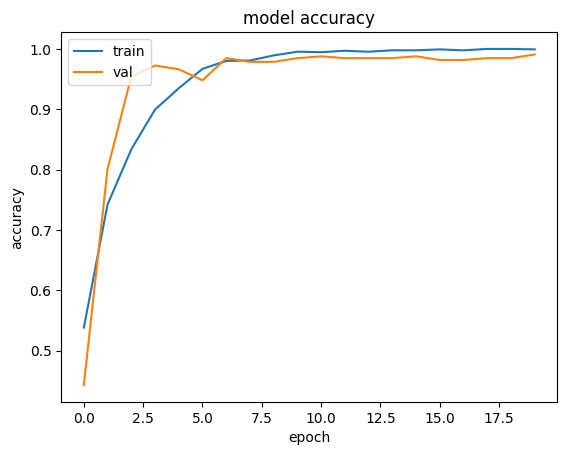

In [ ]:


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



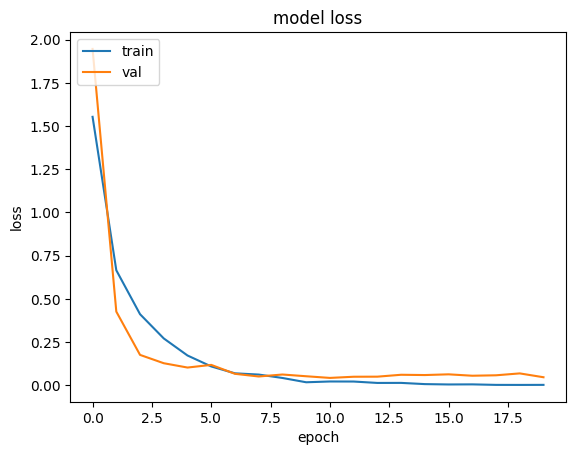

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))


              precision    recall  f1-score   support

   Malignant       1.00      1.00      1.00       157
      Normal       1.00      0.98      0.99       178
      benign       0.98      1.00      0.99       155

    accuracy                           0.99       490
   macro avg       0.99      0.99      0.99       490
weighted avg       0.99      0.99      0.99       490

Accuracy of the Model: 99.4%


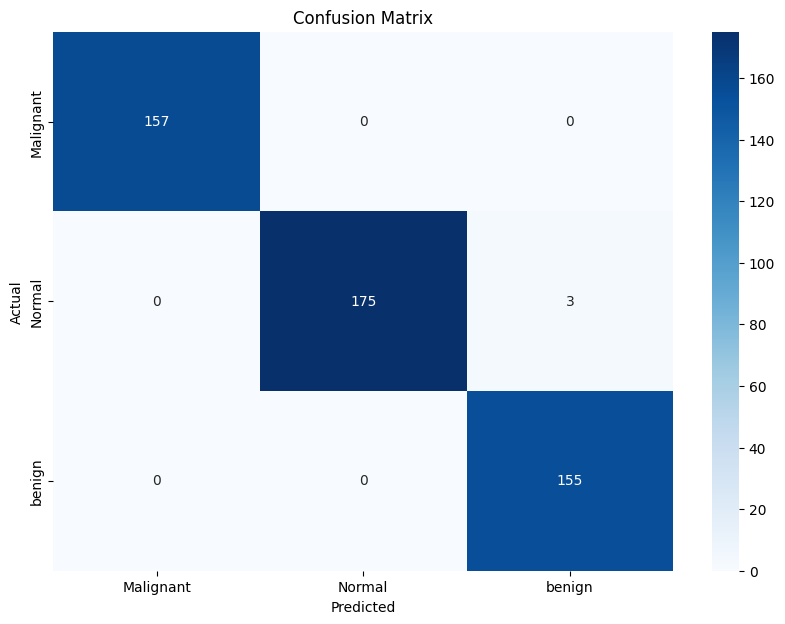

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Malignant', 'Normal', 'benign']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()